In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from importlib import reload

import TunaSims
import solvers

Results for Different Ways of Distributing Interspectral Intensity Difference

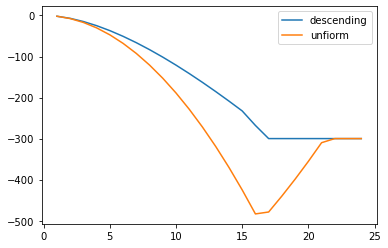

In [2]:
xs=list()
scores_1=list()
scores_2=list()

total_difference = 0.9
len_difference = 10
max_len = 25

func1 = partial(TunaSims.tuna_dif_distance,e=1,f=-1,h=500, i=-3,j=2,k=-800)
func2 = partial(TunaSims.tuna_dif_distance,e=1,f=-1,h=500,i=-3,j=2,k=-800)

normalize = False

for i in range(1,max_len):

    xs.append(i)
    dif_1 = np.array([1/(x+1) for x in range(i)])
    dif_1 = dif_1/sum(dif_1)*total_difference

    dif_2 = np.array([total_difference/i for x in range(i)])

    if normalize:
        scores_1.append(1- 1/func1(dif_1))
        scores_2.append(1 - 1/func2(dif_2))
    else:
        scores_1.append(func1(dif_1, np.zeros(len(dif_1))))
        scores_2.append(func2(dif_2, np.zeros(len(dif_2))))

plt.plot(xs, scores_1, label='descending')
plt.plot(xs, scores_2, label='unfiorm')

plt.legend()
plt.show()

In [3]:
objective_ = partial(TunaSims.objective, loss_func = lambda x: x**2, reg_func= lambda x: 0.1*sum(np.abs(x)), distance_func=TunaSims.tuna_dif_distance)


In [4]:
df_ex = pd.DataFrame([[1,dif_1, np.zeros(len(dif_1))]], columns = ['match', 'query','target'])

In [20]:
solver_res = solvers.scipy_solver_estimate(objective_, df_ex, [1,1,1,1,1], ['a','b','c','d','e'])

In [32]:
solver_res

      fun: 0.17219684731338109
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([9.99999999e-02, 9.99999999e-02, 3.00870442e-06, 8.94951391e-02,
       4.97348829e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 582
      nit: 13
     njev: 97
   status: 0
  success: True
        x: array([ 4.46604395e-09,  4.46604395e-09,  1.04638652e+00, -5.25242994e-10,
       -2.51325593e-09])

In [21]:
solver_res

      fun: 0.17219684731338109
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([9.99999999e-02, 9.99999999e-02, 3.00870442e-06, 8.94951391e-02,
       4.97348829e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 582
      nit: 13
     njev: 97
   status: 0
  success: True
        x: array([ 4.46604395e-09,  4.46604395e-09,  1.04638652e+00, -5.25242994e-10,
       -2.51325593e-09])

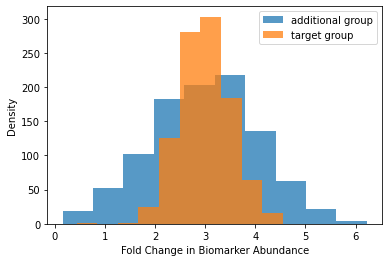

In [68]:
group1 = np.random.normal(3,1,1000)
group2 = np.random.normal(3,0.5,1000)

plt.hist(group1,  label = 'additional group', alpha=0.75)
plt.hist(group2, label='target group', alpha=0.75)
plt.xlabel('Fold Change in Biomarker Abundance')
plt.ylabel('Density')
plt.legend()
plt.show()

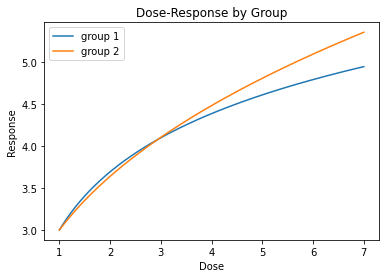

In [51]:
doses = np.linspace(1,7,1000)
func_1_ys = np.log(doses) +3
func_2_ys = 1+ 2*doses**0.4

plt.plot(doses, func_1_ys, label= 'group 1')
plt.plot(doses, func_2_ys, label = 'group 2')
plt.title('Dose-Response by Group')
plt.xlabel('Dose')
plt.ylabel('Response')
plt.legend()
plt.show()

In [3]:

from matplotlib.pyplot import bar
res = pd.read_csv("C:\\Users\\jonah\\Downloads\\10_ppm.csv", header=None)
res.columns=['yool','metric','AUC','clean_specs']
res = res[~res['metric'].str.contains('omd')]

In [114]:
res.sort_values(by='AUC', ascending=False)[:10]

,yool,metric,AUC,clean_specs
270,4,fidelity,0.832371,"n:0.0, c:0.005da, p:orig, pr:True"
279,13,bhattacharya_1,0.832371,"n:0.0, c:0.005da, p:orig, pr:True"
280,14,squared_chord,0.832250,"n:0.0, c:0.005da, p:orig, pr:True"
273,7,matusita,0.832248,"n:0.0, c:0.005da, p:orig, pr:True"
266,0,entropy,0.832225,"n:0.0, c:0.005da, p:orig, pr:True"
267,1,proportional_entropy,0.832169,"n:0.0, c:0.005da, p:orig, pr:True"
251,4,fidelity,0.831796,"n:0.0, c:0.005da, p:logent, pr:True"
260,13,bhattacharya_1,0.831796,"n:0.0, c:0.005da, p:logent, pr:True"
275,9,chi2,0.831739,"n:0.0, c:0.005da, p:orig, pr:True"
247,0,entropy,0.831715,"n:0.0, c:0.005da, p:logent, pr:True"


In [137]:
alpha =0.8
colors = {'entropy':('red',alpha),
            'dot_product':('green',alpha),
            'proportional_entropy':('blue',alpha),
            'lorentzian':('cyan',alpha),
            'cross_ent':('chartreuse',alpha),
            'fidelity':('purple',alpha),
            'proportional_manhattan':('orange',alpha),
            'max_fidelity':('pink',alpha),
            'matusita':('aquamarine',alpha),
            'proportional_lorentzian':('sky blue',alpha),
            'chi2':('magenta', alpha),
            'laplacian':('teal',alpha),
            'max_laplacian':('gray',alpha),
            'harmonic_mean':('olive',alpha),
            'bhattacharya_1':('brown',alpha),
            'squared_chord':('silver',alpha)}

filt_cleans = [['n:0.01, c:0.05da, p:None, pr:True'],['n:0.01, c:0.05da, p:orig, pr:True'],['n:0.01, c:0.005da, p:orig, pr:True'],['n:0.0, c:0.005da, p:orig, pr:True']]
#filt_metrics = list(set(res['metric']))
filt_metrics = ['entropy','dot_product','bhattacharya_1','cross_ent','fidelity','squared_chord']
subs=list()
titles=list()
sub_colors=list()
sub_length = 6

for settings in filt_cleans:

    sub = res[(np.isin(res['clean_specs'],settings)) & ((np.isin(res['metric'],filt_metrics)))]
    sub.sort_values(by='AUC', inplace=True, ascending=False)
    sub=sub[:sub_length]
    colors_ = [colors[i] for i in sub['metric']]
    subs.append(sub)
    sub_colors.append(colors_)
    params = settings[0].split(',')
    titles.append(f'Noise Clipping: {params[0].split(":")[-1]}, Match Tolerance: {params[1].split(":")[-1]}, Reweighting: {params[2].split(":")[-1]}')




C:\Users\jonah\AppData\Local\Temp\ipykernel_17536\2023734344.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub.sort_values(by='AUC', inplace=True, ascending=False)


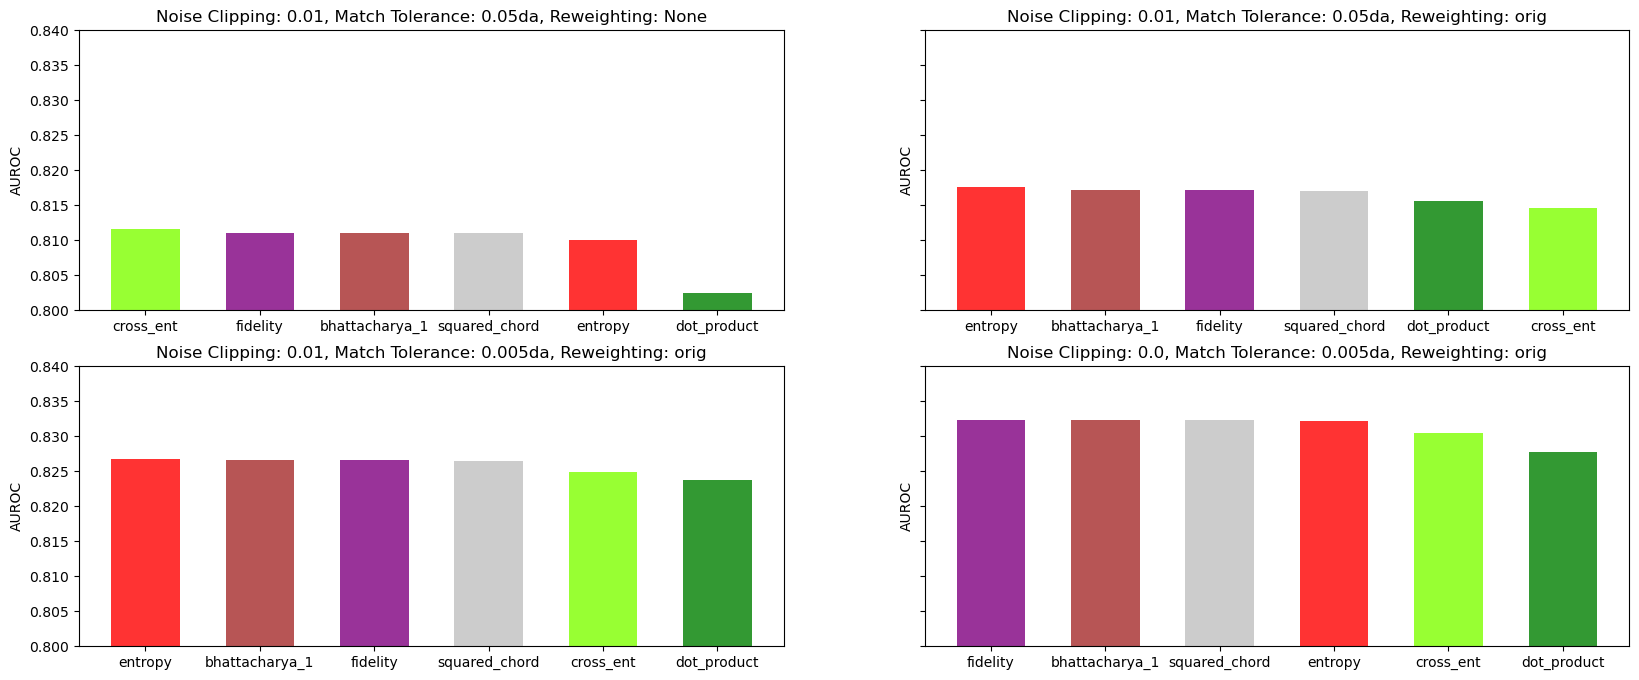

: 

In [152]:
height=len(subs)*2
width=len(subs)*5
fig,axs = plt.subplots(int(len(subs)/2),int(len(subs)/2), sharey=True)
plt.ylim([0.8,0.84])
fig.set_figheight(height)
fig.set_figwidth(width)
for i in range(len(subs)):
    
    axs.flat[i].set_ylabel('AUROC')
    axs.flat[i].set_title(titles[i])
    axs.flat[i].bar(x=subs[i]['metric'],height=subs[i]['AUC'], width=0.6, color=sub_colors[i])

plt.show()

In [1]:
alpha =0.8
colors = {'entropy':('red',alpha),
            'dot_product':('green',alpha),
            'proportional_entropy':('blue',alpha),
            'lorentzian':('cyan',alpha),
            'cross_ent':('chartreuse',alpha),
            'fidelity':('purple',alpha),
            'proportional_manhattan':('orange',alpha),
            'max_fidelity':('pink',alpha),
            'matusita':('aquamarine',alpha),
            'proportional_lorentzian':('sky blue',alpha),
            'chi2':('magenta', alpha),
            'laplacian':('teal',alpha),
            'max_laplacian':('gray',alpha),
            'harmonic_mean':('olive',alpha),
            'bhattacharya_1':('brown',alpha),
            'squared_chord':('silver',alpha)}

filt_cleans = [['n:0.01, c:0.05da, p:None, pr:True'],['n:0.01, c:0.05da, p:orig, pr:True'],['n:0.01, c:0.005da, p:orig, pr:True'],['n:0.0, c:0.005da, p:orig, pr:True']]
#filt_metrics = list(set(res['metric']))
filt_metrics = ['entropy','dot_product','bhattacharya_1','cross_ent','fidelity','squared_chord']
subs=list()
titles=list()
sub_colors=list()
sub_length = 6

for settings in filt_cleans:

    sub = res[(np.isin(res['clean_specs'],settings)) & ((np.isin(res['metric'],filt_metrics)))]
    sub.sort_values(by='AUC', inplace=True, ascending=False)
    sub=sub[:sub_length]
    colors_ = [colors[i] for i in sub['metric']]
    subs.append(sub)
    sub_colors.append(colors_)
    params = settings[0].split(',')
    titles.append(f'Noise Clipping: {params[0].split(":")[-1]}, Match Tolerance: {params[1].split(":")[-1]}, Reweighting: {params[2].split(":")[-1]}')




height=len(subs)*2
width=len(subs)*5
fig,axs = plt.subplots(int(len(subs)/2),int(len(subs)/2), sharey=True)
plt.ylim([0.8,0.84])
fig.set_figheight(height)
fig.set_figwidth(width)
for i in range(len(subs)):
    
    axs.flat[i].set_ylabel('AUROC')
    axs.flat[i].set_title(titles[i])
    axs.flat[i].bar(x=subs[i]['metric'],height=subs[i]['AUC'], width=0.6, color=sub_colors[i])

plt.show()

NameError: name 'res' is not defined